# Running MSAF #

The main MSAF functionality is demonstrated here.

In [75]:
from __future__ import print_function
import msaf
import librosa
import seaborn as sns
import pandas as pd
# and IPython.display for audio output
import IPython.display
from sklearn.preprocessing import MinMaxScaler
import scipy.io.wavfile as wavf
from tree_lib import *
import matplotlib.pyplot as plt
# Setup nice plots
sns.set(style="dark")
%matplotlib inline

## Single File Mode ##

This mode analyzes one audio file at a time.

**Note**: Make sure to download the datasets from https://github.com/urinieto/msaf-data/

In [105]:
df = pd.read_csv("ratings.csv")
child = df.iloc[335]["expression"]
#render_tups = render(df.iloc[0]["expression"], 8000, 15)
#renderings = render_tups[0]

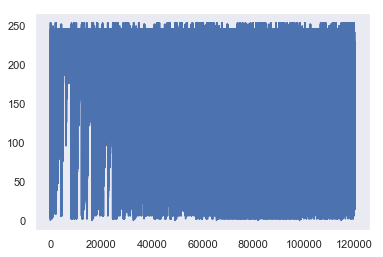

In [106]:
rendering = np.array([[eval(child) % 256] for t in range(8000 * 15)])
plt.plot(rendering)

In [107]:
scaler = MinMaxScaler()
rendering = scaler.fit_transform(rendering)

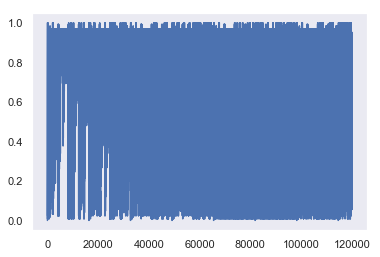

In [108]:
wavf.write("songs/song_338.wav", 8000, rendering.T[0])
arr = wavf.read("songs/song_338.wav")
plt.plot(arr[1])

In [109]:
# Choose an audio file and listen to it
IPython.display.Audio(arr[1], rate=8000)

In [110]:
IPython.display.Audio("songs/song_338.wav")

In [111]:
# Segment the file using the default MSAF parameters
boundaries, labels = msaf.process("songs/song_338.wav")
print(boundaries)

[ 0.          0.55727891  7.70902494 14.95365079 15.        ]


In [131]:
# Sonify boundaries
sonified_file = "my_boundaries.wav"
sr = 44100
boundaries, labels = msaf.process(audio_file, sonify_bounds=True, 
                                  out_bounds=sonified_file, framesync = False, out_sr=sr)

# Listen to results
audio = librosa.load(sonified_file, sr=sr)[0]
IPython.display.Audio(audio, rate=sr)

### Using different Algorithms ###

MSAF includes multiple algorithms both for boundary retrieval and structural grouping (or labeling). In this section we demonstrate how to try them out.

Note: more algorithms are available in [msaf-gpl](https://github.com/urinieto/msaf-gpl).

In [113]:
# First, let's list all the available boundary algorithms
print(msaf.get_all_boundary_algorithms())

['cnmf', 'example', 'foote', 'olda', 'scluster', 'sf', 'vmo']


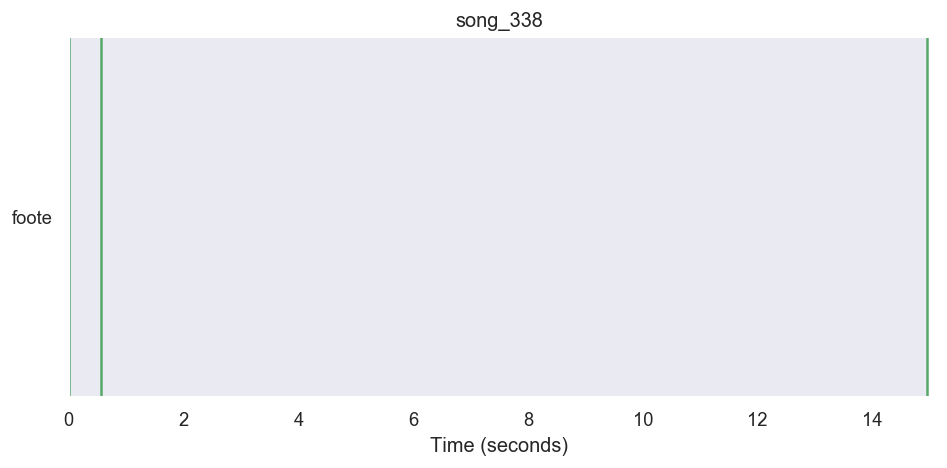

In [115]:
# Try one of these boundary algorithms and print results
boundaries, labels = msaf.process(audio_file, boundaries_id="foote", framse=True)

In [116]:
# Let's check all the structural grouping (label) algorithms available
print(msaf.get_all_label_algorithms())

['cnmf', 'fmc2d', 'scluster', 'vmo']


In [119]:
# Try one of these label algorithms
boundaries, labels = msaf.process(audio_file, boundaries_id="foote", labels_id="fmc2d")
print(boundaries)
print(labels)

[ 0.          0.55727891 14.95365079 15.        ]
[1, 0, 1]


/anaconda3/lib/python3.7/site-packages/msaf/algorithms/foote/segmenter.py:51: RuntimeWarning: invalid value encountered in true_divide
  nc /= nc.max()


In [124]:
# If available, you can use previously annotated boundaries and a specific labels algorithm
# Set plot = True to plot the results
boundaries, labels = msaf.process(audio_file, boundaries_id="foote", 
                                  labels_id="fmc2d", plot=False)

### Using different Features ###

Some algorithms allow the input of different type of features (e.g., harmonic, timbral). In this section we show how we can input different features to MSAF.

In [125]:
# Let's check what available features are there in MSAF
print(msaf.features_registry)

{'cqt': <class 'msaf.features.CQT'>, 'mfcc': <class 'msaf.features.MFCC'>, 'pcp': <class 'msaf.features.PCP'>, 'tonnetz': <class 'msaf.features.Tonnetz'>, 'tempogram': <class 'msaf.features.Tempogram'>}


In [126]:
# Segment the file using the Foote method for boundaries, C-NMF method for labels, and MFCC features
boundaries, labels = msaf.process(audio_file, feature="mfcc", boundaries_id="gt", 
                                  labels_id="fmc2d", plot=True)

ValueError: max() arg is an empty sequence

### Using Annotated Beats ###

MSAF can calculate the beats or use annotated ones. The annotations should be store in a jams file, for this notebook we used a [simple jams example](http://pythonhosted.org/jams/examples.html). 

In [129]:
sr = 44100
hop_length = 1024
beats_audio_file = "songs/song_338.wav"
audio = librosa.load(beats_audio_file, sr=sr)[0]
audio_harmonic, audio_percussive = librosa.effects.hpss(audio)

# Compute beats
tempo, frames = librosa.beat.beat_track(y=audio_percussive, 
                                        sr=sr, hop_length=hop_length)

# To times
beat_times = librosa.frames_to_time(frames, sr=sr, 
                                    hop_length=hop_length)

print(beat_times)

[ 0.53405896  1.04489796  1.55573696  2.06657596  2.57741497  3.08825397
  3.59909297  4.10993197  4.62077098  5.13160998  5.64244898  6.15328798
  6.68734694  7.19818594  7.70902494  8.21986395  8.73070295  9.24154195
  9.75238095 10.26321995 10.77405896]


In [ ]:
#  We will now save or beats to a JAMS file.
import jams

jam = jams.JAMS()
jam.file_metadata.duration = len(audio_file)/sr
beat_a = jams.Annotation(namespace='beat')
beat_a.annotation_metadata = jams.AnnotationMetadata(data_source='librosa beat tracker')

#  Add beat timings to the annotation record.
#  The beat namespace does not require value or confidence fields,
#  so we can leave those blank.
for t in beat_times:
    beat_a.append(time=t, duration=0.0)

#  Store the new annotation in the jam file. This need to be located on the references folder
#  and be named like the audio file except for the jams extension.
jam.annotations.append(beat_a)
jam.save('../datasets/Sargon/references/01-Sargon-Mindless.jams')

In [ ]:
#  Using the annotated beats then is straight forward.
#  Just be sure you don't have a temporary features file in the directory.

boundaries, labels = msaf.process(audio_file, boundaries_id="foote", 
                                  annot_beats=True, labels_id="fmc2d", plot=True)

### Evaluate Results ###

The results can be evaluated as long as there is an existing file containing reference annotations. The results are stored in a pandas DataFrame. MSAF has to run these algorithms (using `msaf.process` described above) before being able to evaluate its results.

In [ ]:
# Evaluate the results. It returns a pandas data frame.
evaluations = msaf.eval.process(audio_file, boundaries_id="foote", labels_id="fmc2d")
IPython.display.display(evaluations)

### Explore Algorithm Parameters ###

Now let's modify the configuration of one of the files, and modify it to see how different the results are.
We will use Widgets, which will become handy here.

In [ ]:
# First, check which are foote's algorithm parameters:
print(msaf.algorithms.foote.config)

In [ ]:
# play around with IPython.Widgets
from ipywidgets import interact

# Obtain the default configuration
bid = "foote"  # Boundaries ID
lid = None     # Labels ID
feature = "pcp"
config = msaf.io.get_configuration(feature, annot_beats=False, framesync=False, 
                                   boundaries_id=bid, labels_id=lid)

# Sweep M_gaussian parameters
@interact(M_gaussian=(50, 500, 25))
def _run_msaf(M_gaussian):
    # Set the configuration
    config["M_gaussian"] = M_gaussian
    
    # Segment the file using the Foote method, and Pitch Class Profiles for the features
    results = msaf.process(audio_file, feature=feature, boundaries_id=bid, 
                           config=config, plot=True)

    # Evaluate the results. It returns a pandas data frame.
    evaluations = msaf.eval.process(audio_file, feature=feature, boundaries_id=bid,
                                    config=config)
    IPython.display.display(evaluations)

## Collection Mode ##

MSAF is able to run and evaluate mutliple files using multi-threading. In this section we show this functionality.

In [ ]:
dataset = "../datasets/Sargon/"
results = msaf.process(dataset, n_jobs=1, boundaries_id="foote")

In [ ]:
# Evaluate in collection mode
evaluations = msaf.eval.process(dataset, n_jobs=4, boundaries_id="foote")
IPython.display.display(evaluations)
IPython.display.display(evaluations.mean())